In [2]:
import os

root = "monkbrill2"
for letterFolder in os.listdir(root):
    path = os.path.join(root, letterFolder)
    files = os.listdir(path)
    print(len(files), letterFolder)

300 Alef
300 Ayin
300 Bet
91 Dalet
300 Gimel
300 He
300 Het
193 Kaf
10 Kaf-final
294 Lamed
300 Mem
300 Mem-medial
130 Nun-final
300 Nun-medial
37 Pe
15 Pe-final
265 Qof
78 Resh
300 Samekh
300 Shin
300 Taw
300 Tet
73 Tsadi-final
300 Tsadi-medial
116 Waw
23 Yod
12 Zayin


In [1]:
import os
from collections import Counter
import shutil
from sklearn.model_selection import train_test_split
from data_management.augmentation.habbakukGenerator import create_letter_image
import cv2
import random
from itertools import chain, combinations
from data_management.augmentation.commonAug import imgResizer, imageRotator, imageShearer, letterImageWarper, imageDilator, imageEroder
from tqdm import tqdm

def duplicates_remover(source_folder, temp_folder, positionThreshold, sizeThreshold):
    shapesDict = {}
    
    for folder in tqdm(os.listdir(source_folder)):
        folder_path = os.path.join(source_folder, folder) # current folder directory
        
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename) # full path to the image we are currently on
            if os.path.isdir(file_path):
              continue
            target_folder = os.path.join(temp_folder, folder) # stuff to make a target directory
            os.makedirs(target_folder, exist_ok = True)
            target_file_path = os.path.join(target_folder, filename)

            split = filename.split("-")[9:13]  # get info about this image
            try: # there are two files in the whole monkbrill2 folder that have a different naming convention (but they are both safe to keep without dataset leakage)

                x_pos, y_pos = int(split[0].split("=")[1]), int(split[1].split("=")[1])
                width, height = int(split[2].split("=")[1]), int(split[3].split("=")[1])
            
                extract_file = filename.split("-")[2]  # which DSS extract this letter image came from

                if extract_file in shapesDict.keys():  # if we're on an image that came from the same DSS extract
                    seen_before = False
                    for know_img in shapesDict[extract_file]:
                        [known_x, known_y, known_width, known_height] = know_img
                        # if their x, y positions are similar, AND they have similar image dimensions; ignore this image
                        if abs(known_x - x_pos) < positionThreshold and abs(known_width - width) < sizeThreshold:
                            if abs(known_y - y_pos) < positionThreshold and abs(known_height - height) < sizeThreshold:
                                seen_before = True
                                break
                
                    if not seen_before:
                        shapesDict[extract_file].append([x_pos, y_pos, width, height])
                        shutil.copy(file_path, target_file_path)
                    else: 
                        pass # image is ignored, its too similar to one we have already

                else:
                    shapesDict[extract_file] = [[x_pos, y_pos, width, height]]                
                    shutil.copy(file_path, target_file_path)
            except:
                shutil.copy(file_path, target_file_path)
            print(target_file_path)

In [13]:
def train_test_val_splitter(temp_folder, outputFolder, validation_set = True, reshape = True, desired_size = 50):
    # put the paths to all of the images here
    filePaths = []
    for root, dirs, files in os.walk(temp_folder):
        for name in files:
            filePaths.append(os.path.join(root, name))


    # get the class label for each image in filePaths
    print(filePaths)
    image_labels = [Path(file_path).parts[-2].split("_")[-1] for file_path in filePaths]

                        #changed '\\' for '/'
    print(image_labels)   
    # make train, validate, testing sets (using the image paths and labels)
    X_train, X_test, y_train, y_test = train_test_split(filePaths, image_labels, test_size=0.3, random_state=0, stratify=image_labels, shuffle=True)

    if validation_set:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train, shuffle=True)

    
    sets = {"test" : (X_test, y_test),
            "train" : (X_train, y_train) 
            }
    
    if validation_set:  sets["validation"] = (X_val, y_val)

    # make train/test(/validation) folders
    for key in sets:
        folderPath = os.path.join(outputFolder, key) # makes the train, validate, test folders
        os.makedirs(folderPath, exist_ok = True)


    # move the files into the folders
    # also resize to 50x50 here, may as well do it now
    for key in sets:
        print(key)
        (filePaths, image_labels) = sets[key]
        print("   ", Counter(image_labels))

        for imgPath, label in zip(filePaths, image_labels):
        
            folderPath = os.path.join(os.path.join(outputFolder, key), label)
            os.makedirs(folderPath, exist_ok = True)  # checks to see if the folder for this class is made (within the train/val or test folders)

            filename = os.path.split(imgPath)[-1]
            
            if not filename.lower().endswith('.jpg'):
                print(f"Skipping file {imgPath} - not a JPEG image")
                continue
                
            target_im_dir = os.path.join(folderPath, filename)
            #print(target_im_dir)

            if reshape:
                img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
                img = imgResizer(img, desired_size=desired_size)  # reshapes to 50x50
                cv2.imwrite(target_im_dir, img)
            else:
                shutil.copy(imgPath, target_im_dir)

            #print(target_im_dir)

    # delete the temporary folder, we're done with it here
    shutil.rmtree(temp_folder)

In [10]:
from pathlib import Path

filePaths = []
for root, dirs, files in os.walk(temp_folder):
        for name in files:
            filePaths.append(os.path.join(root, name))


    # get the class label for each image in filePaths
print(filePaths)
image_labels = [Path(file_path).parts[-2].split("_")[-1] for file_path in filePaths]
print(image_labels)

['Data/dssLettersTemp\\Alef\\navis-QIrug-Qumran_extr09_0001-line-008-y1=400-y2=515-zone-HUMAN-x=1650-y=0049-w=0035-h=0042-ybas=0027-nink=631-segm=COCOS5cocos.jpg', 'Data/dssLettersTemp\\Alef\\navis-QIrug-Qumran_extr09_0001-line-037-y1=1624-y2=1742-zone-HUMAN-x=0403-y=0031-w=0032-h=0050-ybas=0029-nink=580-segm=COCOS5cocos.jpg', 'Data/dssLettersTemp\\Alef\\navis-QIrug-Qumran_extr09_0001-line-070-y1=3105-y2=3227-zone-HUMAN-x=1631-y=0023-w=0034-h=0062-ybas=0061-nink=566-segm=COCOS5cocos.jpg', 'Data/dssLettersTemp\\Alef\\navis-QIrug-Qumran_extr09_0002-line-003-y1=196-y2=314-zone-HUMAN-x=0527-y=0038-w=0037-h=0061-ybas=0068-nink=770-segm=COCOS5cocos.jpg', 'Data/dssLettersTemp\\Alef\\navis-QIrug-Qumran_extr09_0002-line-012-y1=466-y2=616-zone-HUMAN-x=1966-y=0052-w=0037-h=0039-ybas=0056-nink=647-segm=COCOS5cocos.jpg', 'Data/dssLettersTemp\\Alef\\navis-QIrug-Qumran_extr09_0002-line-012-y1=466-y2=616-zone-HUMAN-x=1966-y=0052-w=0048-h=0059-ybas=0056-nink=660-segm=COCOS5cocos.jpg', 'Data/dssLettersT

In [14]:
train_test_val_splitter(temp_folder, outputFolder=target_folder, validation_set=False, reshape=False)

['Data/dssLettersTemp\\Alef\\navis-QIrug-Qumran_extr09_0001-line-008-y1=400-y2=515-zone-HUMAN-x=1650-y=0049-w=0035-h=0042-ybas=0027-nink=631-segm=COCOS5cocos.jpg', 'Data/dssLettersTemp\\Alef\\navis-QIrug-Qumran_extr09_0001-line-037-y1=1624-y2=1742-zone-HUMAN-x=0403-y=0031-w=0032-h=0050-ybas=0029-nink=580-segm=COCOS5cocos.jpg', 'Data/dssLettersTemp\\Alef\\navis-QIrug-Qumran_extr09_0001-line-070-y1=3105-y2=3227-zone-HUMAN-x=1631-y=0023-w=0034-h=0062-ybas=0061-nink=566-segm=COCOS5cocos.jpg', 'Data/dssLettersTemp\\Alef\\navis-QIrug-Qumran_extr09_0002-line-003-y1=196-y2=314-zone-HUMAN-x=0527-y=0038-w=0037-h=0061-ybas=0068-nink=770-segm=COCOS5cocos.jpg', 'Data/dssLettersTemp\\Alef\\navis-QIrug-Qumran_extr09_0002-line-012-y1=466-y2=616-zone-HUMAN-x=1966-y=0052-w=0037-h=0039-ybas=0056-nink=647-segm=COCOS5cocos.jpg', 'Data/dssLettersTemp\\Alef\\navis-QIrug-Qumran_extr09_0002-line-012-y1=466-y2=616-zone-HUMAN-x=1966-y=0052-w=0048-h=0059-ybas=0056-nink=660-segm=COCOS5cocos.jpg', 'Data/dssLettersT

In [3]:
source_folder = "monkbrill2/"           # where the original data is
temp_folder = "Data/dssLettersTemp"     # for intermediate operations, gets deleted when this code is done
target_folder = "Data/dssLetters"       # where to put the final train,test,validate folders


# thresholds for removing 'duplicate' images
positionThreshold = 50 
sizeThreshold = 5

# make test, train, (validation) set folders into the target_folder
validation_set = True  # whether or not we want a seperate validation set (makes the training set smaller)

reshape = True         # if we want to reshape all of the images now
desired_size = 50      # and to what size (eg. 50 is 50x50)


# whether or not to fill in the class imbalance with Habbakuk images
fillClassImbalance = False
fill_amount = 1



augment_training = False  # yes or no augmentaion applied on the whole training set
possible_transforms = ["rotate", "shear", "warp", "erode", "dilate"]
number_of_augmentations = 5   # 5 sets of augmentions per original image

duplicates_remover(source_folder, temp_folder, positionThreshold, sizeThreshold)

  0%|          | 0/27 [00:00<?, ?it/s]

Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr09_0001-line-008-y1=400-y2=515-zone-HUMAN-x=1650-y=0049-w=0035-h=0042-ybas=0027-nink=631-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr09_0001-line-009-y1=426-y2=543-zone-HUMAN-x=1650-y=0023-w=0035-h=0042-ybas=0045-nink=631-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr09_0001-line-037-y1=1624-y2=1742-zone-HUMAN-x=0403-y=0031-w=0032-h=0050-ybas=0029-nink=580-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr09_0001-line-070-y1=3105-y2=3227-zone-HUMAN-x=1631-y=0023-w=0034-h=0062-ybas=0061-nink=566-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr09_0002-line-003-y1=196-y2=314-zone-HUMAN-x=0527-y=0038-w=0037-h=0061-ybas=0068-nink=770-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr09_0002-line-012-y1=466-y2=616-zone-HUMAN-x=1966-y=0052-w=0037-h=0039-ybas=0056-nink=647-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr

  4%|▎         | 1/27 [00:00<00:09,  2.71it/s]

Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr09_0293-line-041-y1=2075-y2=2198-zone-HUMAN-x=3024-y=0049-w=0035-h=0039-ybas=0083-nink=578-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr09_0293-line-042-y1=2109-y2=2222-zone-HUMAN-x=0587-y=0027-w=0034-h=0067-ybas=0049-nink=630-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr09_0293-line-042-y1=2109-y2=2222-zone-HUMAN-x=0587-y=0027-w=0035-h=0067-ybas=0049-nink=634-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr09_0295-line-003-y1=61-y2=180-zone-HUMAN-x=1847-y=0063-w=0034-h=0037-ybas=0075-nink=644-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr09_0295-line-004-y1=91-y2=203-zone-HUMAN-x=1847-y=0033-w=0034-h=0038-ybas=0045-nink=651-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Alef\navis-QIrug-Qumran_extr09_0296-line-058-y1=1723-y2=1838-zone-HUMAN-x=0154-y=0048-w=0035-h=0034-ybas=0065-nink=532-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Alef\navis-QIrug-Qumran_ex

  7%|▋         | 2/27 [00:00<00:08,  2.86it/s]

Data/dssLettersTemp\Ayin\navis-QIrug-Qumran_extr09_1245-line-046-y1=1345-y2=1451-zone-HUMAN-x=1760-y=0020-w=0037-h=0045-ybas=0057-nink=602-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Ayin\navis-QIrug-Qumran_extr09_1245-line-046-y1=1345-y2=1451-zone-HUMAN-x=1760-y=0020-w=0038-h=0045-ybas=0057-nink=575-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Ayin\navis-QIrug-Qumran_extr09_1245-line-070-y1=2154-y2=2266-zone-HUMAN-x=2514-y=0046-w=0038-h=0032-ybas=0036-nink=428-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Ayin\navis-QIrug-Qumran_extr09_1245-line-071-y1=2177-y2=2287-zone-HUMAN-x=2514-y=0023-w=0038-h=0032-ybas=0083-nink=428-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Ayin\navis-QIrug-Qumran_extr09_1252-line-039-y1=1649-y2=1776-zone-HUMAN-x=2073-y=0068-w=0033-h=0040-ybas=0103-nink=494-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Ayin\navis-QIrug-Qumran_extr09_1259-line-042-y1=2075-y2=2181-zone-HUMAN-x=1004-y=0054-w=0042-h=0033-ybas=0078-nink=514-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Ayin\navis-QIrug-Qum

 11%|█         | 3/27 [00:01<00:08,  2.69it/s]

Data/dssLettersTemp\Bet\navis-QIrug-Qumran_extr09_1125-line-040-y1=2431-y2=2549-zone-HUMAN-x=2273-y=0029-w=0040-h=0036-ybas=0057-nink=668-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Bet\navis-QIrug-Qumran_extr09_1133-line-046-y1=1424-y2=1538-zone-HUMAN-x=2688-y=0030-w=0043-h=0047-ybas=0024-nink=550-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Bet\navis-QIrug-Qumran_extr09_1135-line-010-y1=592-y2=716-zone-HUMAN-x=2229-y=0045-w=0041-h=0042-ybas=0100-nink=721-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Bet\navis-QIrug-Qumran_extr09_1135-line-018-y1=814-y2=939-zone-HUMAN-x=2625-y=0034-w=0049-h=0048-ybas=0051-nink=934-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Bet\navis-QIrug-Qumran_extr09_1135-line-032-y1=1347-y2=1453-zone-HUMAN-x=0457-y=0035-w=0041-h=0044-ybas=0047-nink=689-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Bet\navis-QIrug-Qumran_extr09_1135-line-046-y1=2056-y2=2212-zone-HUMAN-x=1236-y=0075-w=0048-h=0037-ybas=0086-nink=718-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Bet\navis-QIrug-Qumran_extr09_

 15%|█▍        | 4/27 [00:01<00:06,  3.50it/s]

Data/dssLettersTemp\Dalet\navis-QIrug-Qumran_extr09_1661-line-043-y1=1639-y2=1749-zone-HUMAN-x=1810-y=0021-w=0041-h=0031-ybas=0038-nink=438-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Dalet\navis-QIrug-Qumran_extr09_1661-line-043-y1=1639-y2=1749-zone-HUMAN-x=1810-y=0021-w=0042-h=0031-ybas=0038-nink=442-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Dalet\navis-QIrug-Qumran_extr09_1708-line-034-y1=2628-y2=2747-zone-HUMAN-x=1981-y=0020-w=0045-h=0067-ybas=0052-nink=965-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Dalet\navis-QIrug-Qumran_extr09_1708-line-034-y1=2628-y2=2747-zone-HUMAN-x=1981-y=0020-w=0046-h=0067-ybas=0052-nink=927-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Dalet\navis-QIrug-Qumran_extr09_1789-line-043-y1=1310-y2=1419-zone-HUMAN-x=0491-y=0038-w=0031-h=0043-ybas=0045-nink=428-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Dalet\navis-QIrug-Qumran_extr09_1958-line-015-y1=713-y2=826-zone-HUMAN-x=2111-y=0033-w=0040-h=0061-ybas=0087-nink=829-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Gimel\navis-QIru

 19%|█▊        | 5/27 [00:01<00:07,  2.89it/s]

Data/dssLettersTemp\Gimel\navis-QIrug-Qumran_extr09_2182-line-024-y1=1388-y2=1493-zone-HUMAN-x=0746-y=0020-w=0046-h=0066-ybas=0052-nink=477-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Gimel\navis-QIrug-Qumran_extr09_2182-line-024-y1=1388-y2=1493-zone-HUMAN-x=0746-y=0020-w=0129-h=0066-ybas=0052-nink=479-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Gimel\navis-QIrug-Qumran_extr09_2182-line-047-y1=2323-y2=2440-zone-HUMAN-x=2112-y=0040-w=0046-h=0056-ybas=0093-nink=483-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Gimel\navis-QIrug-Qumran_extr09_2182-line-048-y1=2351-y2=2474-zone-HUMAN-x=1207-y=0058-w=0042-h=0042-ybas=0067-nink=362-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Gimel\navis-QIrug-Qumran_extr09_2182-line-048-y1=2351-y2=2474-zone-HUMAN-x=2112-y=0027-w=0046-h=0071-ybas=0067-nink=483-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Gimel\navis-QIrug-Qumran_extr09_2182-line-049-y1=2385-y2=2509-zone-HUMAN-x=1207-y=0024-w=0042-h=0042-ybas=0033-nink=362-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Gimel\navis-QI

 22%|██▏       | 6/27 [00:02<00:07,  2.85it/s]

Data/dssLettersTemp\He\navis-QIrug-Qumran_extr09_2453-line-005-y1=711-y2=879-zone-HUMAN-x=0880-y=0072-w=0037-h=0040-ybas=0081-nink=555-segm=COCOS5cocos.jpg
Data/dssLettersTemp\He\navis-QIrug-Qumran_extr09_2453-line-011-y1=1196-y2=1366-zone-HUMAN-x=0808-y=0066-w=0038-h=0037-ybas=0082-nink=506-segm=COCOS5cocos.jpg
Data/dssLettersTemp\He\navis-QIrug-Qumran_extr09_2453-line-030-y1=2575-y2=2744-zone-HUMAN-x=1042-y=0073-w=0035-h=0038-ybas=0083-nink=480-segm=COCOS5cocos.jpg
Data/dssLettersTemp\He\navis-QIrug-Qumran_extr09_2454-line-014-y1=1226-y2=1360-zone-HUMAN-x=1117-y=0039-w=0042-h=0040-ybas=0064-nink=582-segm=COCOS5cocos.jpg
Data/dssLettersTemp\He\navis-QIrug-Qumran_extr09_2454-line-014-y1=1226-y2=1360-zone-HUMAN-x=1649-y=0020-w=0039-h=0034-ybas=0064-nink=499-segm=COCOS5cocos.jpg
Data/dssLettersTemp\He\navis-QIrug-Qumran_extr09_2454-line-017-y1=1359-y2=1488-zone-HUMAN-x=1575-y=0056-w=0038-h=0034-ybas=0095-nink=535-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Het\navis-QIrug-Qumran_extr09_0366

 26%|██▌       | 7/27 [00:02<00:07,  2.63it/s]

Data/dssLettersTemp\Het\navis-QIrug-Qumran_extr09_1313-line-023-y1=1049-y2=1217-zone-HUMAN-x=1907-y=0116-w=0038-h=0033-ybas=0135-nink=541-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Het\navis-QIrug-Qumran_extr09_1313-line-050-y1=1822-y2=1946-zone-HUMAN-x=1502-y=0072-w=0037-h=0033-ybas=0090-nink=524-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Het\navis-QIrug-Qumran_extr09_1314-line-005-y1=650-y2=786-zone-HUMAN-x=2495-y=0020-w=0036-h=0038-ybas=0052-nink=625-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Het\navis-QIrug-Qumran_extr09_1314-line-008-y1=804-y2=937-zone-HUMAN-x=2610-y=0058-w=0038-h=0045-ybas=0094-nink=693-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Het\navis-QIrug-Qumran_extr09_1314-line-023-y1=1605-y2=1743-zone-HUMAN-x=1684-y=0073-w=0035-h=0046-ybas=0100-nink=662-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Het\navis-QIrug-Qumran_extr09_1314-line-024-y1=1654-y2=1792-zone-HUMAN-x=1091-y=0037-w=0038-h=0046-ybas=0051-nink=723-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Het\navis-QIrug-Qumran_extr09_

 30%|██▉       | 8/27 [00:02<00:06,  2.92it/s]

Data/dssLettersTemp\Kaf\navis-QIrug-Qumran_extr09_1649-line-013-y1=1464-y2=1639-zone-HUMAN-x=2335-y=0080-w=0036-h=0048-ybas=0093-nink=717-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Kaf\navis-QIrug-Qumran_extr09_1649-line-015-y1=1603-y2=1737-zone-HUMAN-x=2286-y=0032-w=0032-h=0043-ybas=0048-nink=544-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Kaf\navis-QIrug-Qumran_extr09_1650-line-010-y1=922-y2=1056-zone-HUMAN-x=0876-y=0063-w=0034-h=0049-ybas=0094-nink=615-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Kaf\navis-QIrug-Qumran_extr09_1650-line-011-y1=967-y2=1101-zone-HUMAN-x=0876-y=0020-w=0034-h=0047-ybas=0049-nink=601-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Kaf\navis-QIrug-Qumran_extr09_1650-line-030-y1=1695-y2=1847-zone-HUMAN-x=2497-y=0040-w=0031-h=0044-ybas=0045-nink=532-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Kaf\navis-QIrug-Qumran_extr09_1651-line-005-y1=707-y2=876-zone-HUMAN-x=0937-y=0081-w=0033-h=0043-ybas=0088-nink=556-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Kaf\navis-QIrug-Qumran_extr09_

 37%|███▋      | 10/27 [00:03<00:04,  3.50it/s]

Data/dssLettersTemp\Lamed\navis-QIrug-Qumran_extr09_1318-line-021-y1=1175-y2=1291-zone-HUMAN-x=1334-y=0020-w=0037-h=0061-ybas=0054-nink=593-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Lamed\navis-QIrug-Qumran_extr09_1318-line-021-y1=1175-y2=1291-zone-HUMAN-x=2124-y=0020-w=0035-h=0056-ybas=0054-nink=465-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Lamed\navis-QIrug-Qumran_extr09_1318-line-024-y1=1285-y2=1397-zone-HUMAN-x=1552-y=0020-w=0034-h=0054-ybas=0054-nink=489-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Lamed\navis-QIrug-Qumran_extr09_1318-line-028-y1=1502-y2=1611-zone-HUMAN-x=1140-y=0020-w=0037-h=0066-ybas=0065-nink=591-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Lamed\navis-QIrug-Qumran_extr09_1318-line-028-y1=1502-y2=1611-zone-HUMAN-x=1643-y=0020-w=0042-h=0064-ybas=0065-nink=749-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Lamed\navis-QIrug-Qumran_extr09_1318-line-028-y1=1502-y2=1611-zone-HUMAN-x=1737-y=0020-w=0037-h=0067-ybas=0065-nink=647-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Lamed\navis-QI

 41%|████      | 11/27 [00:03<00:04,  3.33it/s]

Data/dssLettersTemp\Mem\navis-QIrug-Qumran_extr09_1815-line-021-y1=1987-y2=2159-zone-HUMAN-x=1887-y=0057-w=0040-h=0065-ybas=0084-nink=889-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Mem\navis-QIrug-Qumran_extr09_1847-line-019-y1=900-y2=1014-zone-HUMAN-x=0937-y=0047-w=0037-h=0045-ybas=0079-nink=709-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Mem\navis-QIrug-Qumran_extr09_1847-line-019-y1=900-y2=1014-zone-HUMAN-x=0937-y=0047-w=0038-h=0045-ybas=0079-nink=703-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Mem\navis-QIrug-Qumran_extr09_1847-line-020-y1=925-y2=1035-zone-HUMAN-x=0937-y=0022-w=0037-h=0045-ybas=0054-nink=709-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Mem\navis-QIrug-Qumran_extr09_1847-line-020-y1=925-y2=1035-zone-HUMAN-x=0937-y=0022-w=0038-h=0045-ybas=0054-nink=703-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Mem\navis-QIrug-Qumran_extr09_1851-line-031-y1=966-y2=1091-zone-HUMAN-x=0467-y=0020-w=0030-h=0061-ybas=0040-nink=676-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Mem\navis-QIrug-Qumran_extr09_1

 44%|████▍     | 12/27 [00:03<00:04,  3.12it/s]

Data/dssLettersTemp\Mem-medial\navis-QIrug-Qumran_extr09_2411-line-042-y1=1252-y2=1377-zone-HUMAN-x=0394-y=0041-w=0033-h=0043-ybas=0048-nink=610-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Mem-medial\navis-QIrug-Qumran_extr09_2411-line-055-y1=1884-y2=1996-zone-HUMAN-x=0302-y=0038-w=0028-h=0051-ybas=0056-nink=594-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Mem-medial\navis-QIrug-Qumran_extr09_2411-line-056-y1=1907-y2=2037-zone-HUMAN-x=0302-y=0020-w=0028-h=0046-ybas=0033-nink=544-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Mem-medial\navis-QIrug-Qumran_extr09_2413-line-004-y1=132-y2=247-zone-HUMAN-x=0259-y=0020-w=0037-h=0039-ybas=0090-nink=498-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Mem-medial\navis-QIrug-Qumran_extr09_2413-line-004-y1=132-y2=247-zone-HUMAN-x=0259-y=0020-w=0044-h=0039-ybas=0090-nink=504-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Mem-medial\navis-QIrug-Qumran_extr09_2413-line-004-y1=132-y2=247-zone-HUMAN-x=0259-y=0020-w=0046-h=0039-ybas=0090-nink=506-segm=COCOS5cocos.jpg
Data/dssLe

 48%|████▊     | 13/27 [00:04<00:03,  3.51it/s]

Data/dssLettersTemp\Nun-final\navis-QIrug-Qumran_extr09_2181-line-009-y1=634-y2=765-zone-HUMAN-x=0150-y=0055-w=0023-h=0057-ybas=0099-nink=388-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Nun-final\navis-QIrug-Qumran_extr09_2181-line-020-y1=1019-y2=1141-zone-HUMAN-x=2424-y=0020-w=0025-h=0062-ybas=0093-nink=397-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Nun-final\navis-QIrug-Qumran_extr09_2182-line-005-y1=590-y2=711-zone-HUMAN-x=2461-y=0030-w=0021-h=0072-ybas=0047-nink=522-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Nun-final\navis-QIrug-Qumran_extr09_2184-line-017-y1=1781-y2=1909-zone-HUMAN-x=0669-y=0041-w=0017-h=0062-ybas=0047-nink=286-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Nun-final\navis-QIrug-Qumran_extr09_2184-line-017-y1=1781-y2=1909-zone-HUMAN-x=0669-y=0041-w=0021-h=0062-ybas=0047-nink=282-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Nun-final\navis-QIrug-Qumran_extr09_2196-line-023-y1=1462-y2=1595-zone-HUMAN-x=1731-y=0033-w=0021-h=0053-ybas=0049-nink=390-segm=COCOS5cocos.jpg
Data/dssLetter

 52%|█████▏    | 14/27 [00:04<00:04,  3.03it/s]

Data/dssLettersTemp\Nun-medial\navis-QIrug-Qumran_extr09_2211-line-009-y1=762-y2=897-zone-HUMAN-x=1807-y=0066-w=0032-h=0043-ybas=0102-nink=411-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Nun-medial\navis-QIrug-Qumran_extr09_2211-line-021-y1=1192-y2=1323-zone-HUMAN-x=1966-y=0064-w=0032-h=0041-ybas=0098-nink=369-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Nun-medial\navis-QIrug-Qumran_extr09_2211-line-022-y1=1234-y2=1347-zone-HUMAN-x=1966-y=0022-w=0032-h=0041-ybas=0056-nink=369-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Nun-medial\navis-QIrug-Qumran_extr09_2211-line-041-y1=1924-y2=2055-zone-HUMAN-x=0821-y=0039-w=0033-h=0048-ybas=0051-nink=446-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Nun-medial\navis-QIrug-Qumran_extr09_2211-line-050-y1=2216-y2=2339-zone-HUMAN-x=2422-y=0045-w=0032-h=0045-ybas=0092-nink=396-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Nun-medial\navis-QIrug-Qumran_extr09_2212-line-013-y1=1027-y2=1164-zone-HUMAN-x=2485-y=0033-w=0026-h=0041-ybas=0101-nink=302-segm=COCOS5cocos.jpg
Data/d

 63%|██████▎   | 17/27 [00:04<00:02,  4.60it/s]

Data/dssLettersTemp\Qof\navis-QIrug-Qumran_extr09_1793-line-043-y1=1977-y2=2117-zone-HUMAN-x=0939-y=0049-w=0033-h=0039-ybas=0060-nink=392-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Qof\navis-QIrug-Qumran_extr09_1815-line-004-y1=766-y2=949-zone-HUMAN-x=1214-y=0069-w=0038-h=0058-ybas=0086-nink=824-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Qof\navis-QIrug-Qumran_extr09_1831-line-007-y1=607-y2=737-zone-HUMAN-x=1815-y=0057-w=0051-h=0047-ybas=0077-nink=819-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Qof\navis-QIrug-Qumran_extr09_1831-line-008-y1=648-y2=769-zone-HUMAN-x=1815-y=0020-w=0051-h=0043-ybas=0036-nink=771-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Qof\navis-QIrug-Qumran_extr09_1885-line-068-y1=2239-y2=2381-zone-HUMAN-x=2357-y=0038-w=0046-h=0054-ybas=0084-nink=829-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Qof\navis-QIrug-Qumran_extr09_1930-line-019-y1=893-y2=1025-zone-HUMAN-x=2636-y=0054-w=0039-h=0051-ybas=0071-nink=687-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Qof\navis-QIrug-Qumran_extr09_201

 70%|███████   | 19/27 [00:05<00:01,  4.43it/s]

Data/dssLettersTemp\Samekh\navis-QIrug-Qumran_extr09_1652-line-005-y1=464-y2=612-zone-HUMAN-x=0862-y=0052-w=0045-h=0045-ybas=0040-nink=795-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Samekh\navis-QIrug-Qumran_extr09_1652-line-011-y1=788-y2=922-zone-HUMAN-x=2682-y=0058-w=0040-h=0039-ybas=0091-nink=666-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Samekh\navis-QIrug-Qumran_extr09_1652-line-014-y1=922-y2=1070-zone-HUMAN-x=0615-y=0061-w=0046-h=0044-ybas=0048-nink=784-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Samekh\navis-QIrug-Qumran_extr09_1652-line-024-y1=1417-y2=1552-zone-HUMAN-x=1856-y=0074-w=0044-h=0042-ybas=0088-nink=735-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Samekh\navis-QIrug-Qumran_extr09_1652-line-025-y1=1463-y2=1570-zone-HUMAN-x=1017-y=0052-w=0047-h=0036-ybas=0042-nink=694-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Samekh\navis-QIrug-Qumran_extr09_1652-line-025-y1=1463-y2=1570-zone-HUMAN-x=1856-y=0028-w=0044-h=0045-ybas=0042-nink=757-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Samekh\navis-

 74%|███████▍  | 20/27 [00:05<00:01,  3.91it/s]

Data/dssLettersTemp\Shin\navis-QIrug-Qumran_extr09_2451-line-036-y1=2520-y2=2688-zone-HUMAN-x=1691-y=0070-w=0048-h=0038-ybas=0083-nink=639-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Shin\navis-QIrug-Qumran_extr09_2452-line-004-y1=618-y2=757-zone-HUMAN-x=1244-y=0049-w=0047-h=0030-ybas=0072-nink=480-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Shin\navis-QIrug-Qumran_extr09_2452-line-029-y1=1682-y2=1871-zone-HUMAN-x=2348-y=0053-w=0047-h=0039-ybas=0064-nink=641-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Shin\navis-QIrug-Qumran_extr09_2452-line-030-y1=1782-y2=1990-zone-HUMAN-x=2167-y=0080-w=0050-h=0060-ybas=0118-nink=669-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Shin\navis-QIrug-Qumran_extr09_2452-line-032-y1=1957-y2=2085-zone-HUMAN-x=1285-y=0032-w=0042-h=0036-ybas=0039-nink=454-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Shin\navis-QIrug-Qumran_extr09_2452-line-041-y1=2488-y2=2616-zone-HUMAN-x=0373-y=0044-w=0045-h=0036-ybas=0026-nink=608-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Shin\navis-QIrug-Qumra

 78%|███████▊  | 21/27 [00:06<00:01,  3.89it/s]

Data/dssLettersTemp\Taw\navis-QIrug-Qumran_extr09_2190-line-008-y1=904-y2=1074-zone-HUMAN-x=1207-y=0075-w=0033-h=0038-ybas=0084-nink=470-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Taw\navis-QIrug-Qumran_extr09_2190-line-010-y1=1061-y2=1230-zone-HUMAN-x=1001-y=0071-w=0029-h=0039-ybas=0083-nink=407-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Taw\navis-QIrug-Qumran_extr09_2190-line-019-y1=1804-y2=1975-zone-HUMAN-x=0925-y=0062-w=0032-h=0041-ybas=0081-nink=569-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Taw\navis-QIrug-Qumran_extr09_2190-line-021-y1=1966-y2=2128-zone-HUMAN-x=0914-y=0065-w=0032-h=0042-ybas=0087-nink=578-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Taw\navis-QIrug-Qumran_extr09_2190-line-021-y1=1966-y2=2128-zone-HUMAN-x=1167-y=0071-w=0035-h=0044-ybas=0087-nink=593-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Taw\navis-QIrug-Qumran_extr09_2190-line-023-y1=2085-y2=2219-zone-HUMAN-x=2156-y=0042-w=0039-h=0043-ybas=0049-nink=584-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Taw\navis-QIrug-Qumran_extr

 81%|████████▏ | 22/27 [00:06<00:01,  3.51it/s]

Data/dssLettersTemp\Tet\navis-QIrug-Qumran_extr09_1894-line-030-y1=922-y2=1045-zone-HUMAN-x=0479-y=0046-w=0035-h=0035-ybas=0062-nink=580-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Tet\navis-QIrug-Qumran_extr09_1906-line-067-y1=2216-y2=2359-zone-HUMAN-x=1775-y=0047-w=0035-h=0061-ybas=0086-nink=601-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Tet\navis-QIrug-Qumran_extr09_1906-line-067-y1=2216-y2=2359-zone-HUMAN-x=1775-y=0047-w=0037-h=0061-ybas=0086-nink=598-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Tet\navis-QIrug-Qumran_extr09_1927-line-051-y1=2086-y2=2223-zone-HUMAN-x=0483-y=0047-w=0041-h=0041-ybas=0044-nink=697-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Tet\navis-QIrug-Qumran_extr09_1959-line-004-y1=324-y2=443-zone-HUMAN-x=2911-y=0020-w=0054-h=0072-ybas=0059-nink=1120-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Tet\navis-QIrug-Qumran_extr09_1959-line-006-y1=383-y2=495-zone-HUMAN-x=2606-y=0020-w=0059-h=0060-ybas=0065-nink=1264-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Tet\navis-QIrug-Qumran_extr09

 93%|█████████▎| 25/27 [00:06<00:00,  4.48it/s]

Data/dssLettersTemp\Tsadi-medial\navis-QIrug-Qumran_extr09_2213-line-034-y1=1268-y2=1383-zone-HUMAN-x=1737-y=0034-w=0033-h=0056-ybas=0028-nink=686-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Tsadi-medial\navis-QIrug-Qumran_extr09_2213-line-037-y1=1345-y2=1461-zone-HUMAN-x=2011-y=0038-w=0036-h=0045-ybas=0024-nink=501-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Tsadi-medial\navis-QIrug-Qumran_extr09_2213-line-044-y1=1522-y2=1633-zone-HUMAN-x=1788-y=0036-w=0032-h=0045-ybas=0024-nink=503-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Tsadi-medial\navis-QIrug-Qumran_extr09_2213-line-049-y1=1648-y2=1760-zone-HUMAN-x=0869-y=0026-w=0038-h=0047-ybas=0052-nink=589-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Tsadi-medial\navis-QIrug-Qumran_extr09_2213-line-051-y1=1694-y2=1805-zone-HUMAN-x=1458-y=0040-w=0037-h=0044-ybas=0086-nink=509-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Tsadi-medial\navis-QIrug-Qumran_extr09_2213-line-052-y1=1716-y2=1821-zone-HUMAN-x=1458-y=0020-w=0037-h=0042-ybas=0064-nink=498-segm=COCOS5co

100%|██████████| 27/27 [00:07<00:00,  3.82it/s]

Data/dssLettersTemp\Yod\navis-QIrug-Qumran_extr09_0004-line-004-y1=425-y2=547-zone-HUMAN-x=1283-y=0048-w=0034-h=0040-ybas=0082-nink=453-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Yod\navis-QIrug-Qumran_extr09_0053-line-015-y1=1140-y2=1302-zone-HUMAN-x=2221-y=0071-w=0039-h=0041-ybas=0082-nink=540-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Yod\navis-QIrug-Qumran_extr09_0351-line-024-y1=1378-y2=1501-zone-HUMAN-x=2022-y=0048-w=0040-h=0056-ybas=0088-nink=557-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Yod\navis-QIrug-Qumran_extr09_0360-line-013-y1=1141-y2=1285-zone-HUMAN-x=0492-y=0087-w=0036-h=0038-ybas=0100-nink=485-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Yod\navis-QIrug-Qumran_extr09_0708-line-025-y1=1285-y2=1435-zone-HUMAN-x=1922-y=0020-w=0047-h=0035-ybas=0027-nink=580-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Yod\navis-QIrug-Qumran_extr09_0708-line-025-y1=1285-y2=1435-zone-HUMAN-x=1922-y=0020-w=0052-h=0035-ybas=0027-nink=576-segm=COCOS5cocos.jpg
Data/dssLettersTemp\Yod\navis-QIrug-Qumran_extr0

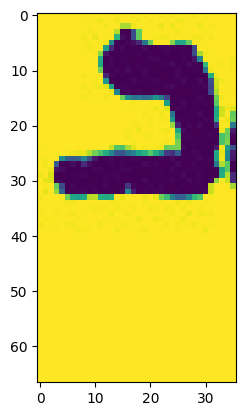

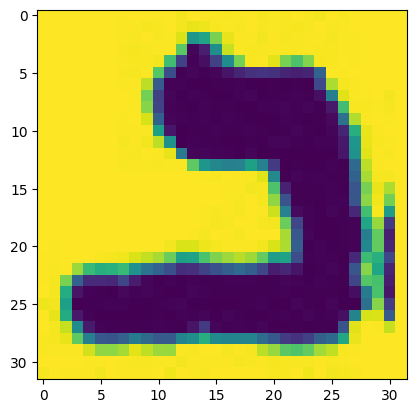

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def whitespaceRemover(img, padding=5):  
    #gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) # Read in the image and convert to grayscale
    imHeight, imWidth = img.shape # get the image dimensions
    
    gray_img = img.copy()
    gray_img = 255*(gray_img < 128).astype(np.uint8) # To invert the text to white
    gray = cv2.morphologyEx(gray_img, cv2.MORPH_OPEN, np.ones((2, 2), dtype=np.uint8)) # Perform noise filtering
    coords = cv2.findNonZero(gray_img) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box

    # pad each side
    y_min = y-padding if y-padding>=0 else 0
    y_max = y+h+padding if y+h+padding<=imHeight else imHeight
    x_min = x-padding if x-padding>=0 else 0
    x_max = x+w+padding if x+w+padding<=imWidth else imWidth

    cropped_im = img[y_min:y_max, x_min:x_max] # Crop the image - note we do this on the original image
    
    return cropped_im


def imgResizer(img, desired_size=32):
    old_size = img.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    img = cv2.resize(img, (new_size[1], new_size[0]), cv2.INTER_NEAREST)

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [255, 255, 255]
    new_im = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    #_, new_im = cv2.threshold(new_im, 0, 255, cv2.THRESH_OTSU)

    return new_im

# INTER_NEAREST
# INTER_LINEAR
# INTER_AREA 
# INTER_CUBIC 
# INTER_LANCZOS4

path = "monkbrill2/Bet/navis-QIrug-Qumran_extr09_0307-line-028-y1=1633-y2=1762-zone-HUMAN-x=2072-y=0032-w=0036-h=0067-ybas=0042-nink=477-segm=COCOS5cocos.jpg"

img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.show()
img = whitespaceRemover(img, padding=3)
img = imgResizer(img, desired_size=32)
plt.imshow(img)
plt.show()


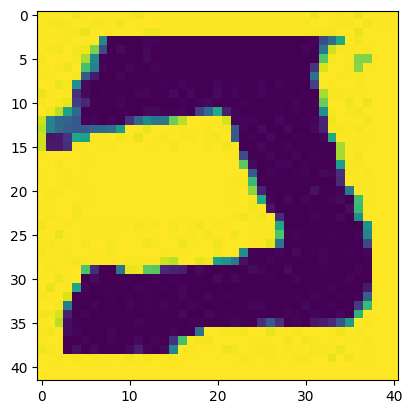

In [84]:
path2 ="monkbrill2/Bet/navis-QIrug-Qumran_extr09_0313-line-026-y1=845-y2=957-zone-HUMAN-x=2072-y=0020-w=0043-h=0073-ybas=0078-nink=731-segm=COCOS5cocos.jpg"

img2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
#img2 = cv2.morphologyEx(img2, cv2.MORPH_CLOSE, np.ones((3, 3), dtype=np.uint8))



def whitespaceRemover(img, padding=5):  
    imHeight, imWidth = img.shape # get the image dimensions
    # find the BB of the contents of the image
    gray_img = img.copy()
    

    gray_img = 255*(gray_img < 128).astype(np.uint8) # To invert the text to white
    gray_img = cv2.morphologyEx(gray_img, cv2.MORPH_OPEN, np.ones((5, 5), dtype=np.uint8)) # Perform noise filtering
    coords = cv2.findNonZero(gray_img) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box

    # pad each side
    y_min = y-padding if y-padding>=0 else 0
    y_max = y+h+padding if y+h+padding<=imHeight else imHeight
    x_min = x-padding if x-padding>=0 else 0
    x_max = x+w+padding if x+w+padding<=imWidth else imWidth

    cropped_img = img[y_min:y_max, x_min:x_max] # Crop the image - note we do this on the original image
    
    return cropped_img

img2 = whitespaceRemover(img2, padding=3)
plt.imshow(img2)
plt.show()

In [1]:
from segment import Segment
import matplotlib.pyplot as plt

segmenter = Segment(input_folder="image-data")
morph = segmenter.segment_characters()

'processing image 0 out of 20'
(2706, 3608, 3)


AttributeError: 'int' object has no attribute 'write'

In [1]:
from segment import Segment

#if __name__ == "__main__":
    #a = Segment()
    #a = Segment("/home/lucypher/Desktop/HandRec/Project/image-data/image-data")
a = Segment("image-data")
a.segment_characters(real_data=True, generated_data=False)

'processing image 0 out of 20'
'processing image 1 out of 20'
'processing image 2 out of 20'
'processing image 3 out of 20'
'processing image 4 out of 20'
'processing image 5 out of 20'
'processing image 6 out of 20'
'processing image 7 out of 20'
'processing image 8 out of 20'
'processing image 9 out of 20'
'processing image 10 out of 20'
'processing image 11 out of 20'
'processing image 12 out of 20'
'processing image 13 out of 20'
'processing image 14 out of 20'
'processing image 15 out of 20'
'processing image 16 out of 20'
'processing image 17 out of 20'
'processing image 18 out of 20'
'processing image 19 out of 20'


In [ ]:
cv2.im

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# crops the image down to only where the text is (i.e. removes whitespace)
# 'padding' indicates how many pixels of whitespace to keep around the far edges of boudning box containing all of the text
def whitespaceRemover(filename, padding=10):  
    gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) # Read in the image and convert to grayscale
    imHeight, imWidth = gray.shape # get the image dimensions
    
    gray = 255*(gray < 128).astype(np.uint8) # To invert the text to white
    gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, np.ones((2, 2), dtype=np.uint8)) # Perform noise filtering
    coords = cv2.findNonZero(gray) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box

    # pad each side
    y_min = y-padding if y-padding>=0 else 0
    y_max = y+h+padding if y+h+padding<=imHeight else imHeight
    x_min = x-padding if x-padding>=0 else 0
    x_max = x+w+padding if x+w+padding<=imWidth else imWidth

    rect = img[y_min:y_max, x_min:x_max] # Crop the image - note we do this on the original image
    
    return rect
"""
path = "Data/Letters/train/Nun-final/Nun-final_12_348.png"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.show()
img = whitespaceRemover(path)
plt.imshow(img)
plt.show()"""

'\npath = "Data/Letters/train/Nun-final/Nun-final_12_348.png"\nimg = cv2.imread(path, cv2.IMREAD_GRAYSCALE)\nplt.imshow(img)\nplt.show()\nimg = whitespaceRemover(path)\nplt.imshow(img)\nplt.show()'

# Removing duplicates

In [38]:
temp = [True, False, True]
sum(temp)

2

In [127]:
import os
from collections import Counter
import shutil
import matplotlib.pyplot as plt

goodOutputsFolder = "Data\\letters_temp"
os.makedirs(goodOutputsFolder, exist_ok = True)
badOutputsFolder = "Data\\shit"
os.makedirs(badOutputsFolder, exist_ok = True)

root = "monkbrill2/"
extracts = []
shapesDict = {}

positionThreshold = 50
dimensionThreshold = 5

kept_list = []
discarded_list = []
letter_classes = []

print("kept, discarded, letter class")

for folder in os.listdir(root):
    discarded = 0
    kept = 0
    folder_path = os.path.join(root, folder)
    
    for filename in os.listdir(folder_path):
        split = filename.split("-")[9:13]
        file_path = os.path.join(folder_path, filename)

        target_folder = os.path.join(goodOutputsFolder, folder)
        os.makedirs(target_folder, exist_ok = True)
        target_file_path = os.path.join(target_folder, filename)

        try: # there are two files in the whole monkbrill2 folder that have a different naming convention (but they are both safe to keep without dataset leakage)

            x_pos, y_pos = int(split[0].split("=")[1]), int(split[1].split("=")[1])
            width, height = int(split[2].split("=")[1]), int(split[3].split("=")[1])
        
            extract_file = filename.split("-")[2]  # which DSS extract this letter image came from

            if extract_file in shapesDict.keys():
                seen_before = False
                for know_img in shapesDict[extract_file]:
                    [known_x, known_y, known_width, known_height] = know_img
                    # if their x, y positions are similar, AND they have similar image dimensions; ignore this image
                    if abs(known_x - x_pos) < positionThreshold and abs(known_width - width) < dimensionThreshold:
                        if abs(known_y - y_pos) < positionThreshold and abs(known_height - height) < dimensionThreshold:
                            seen_before = True
                            break
                                
                if not seen_before:
                    shapesDict[extract_file].append([x_pos, y_pos, width, height])
                    shutil.copy(file_path, target_file_path)
                    kept +=1
                else: 
                    discarded += 1
                    target_file_path = os.path.join(badOutputsFolder, filename)
                    shutil.copy(file_path, target_file_path)

            else:
                shapesDict[extract_file] = [[x_pos, y_pos, width, height]]
                kept +=1
                
                shutil.copy(file_path, target_file_path)
        #extracts.append(split2)
        #print(x_pos, y_pos)
        #print(width, height)
        except:
            #print(filename)
            kept +=1
            shutil.copy(file_path, target_file_path)


    print(kept, discarded, folder)
    kept_list.append(kept)
    discarded_list.append(discarded)
    letter_classes.append(folder)

kept, discarded, letter class
255 45 Alef
248 52 Ayin
250 50 Bet
74 17 Dalet
253 47 Gimel
259 41 He
247 53 Het
169 24 Kaf
9 1 Kaf-final
276 18 Lamed
256 44 Mem
245 55 Mem-medial
122 8 Nun-final
253 47 Nun-medial
30 7 Pe
15 0 Pe-final
234 31 Qof
66 12 Resh
249 51 Samekh
220 80 Shin
230 70 Taw
228 72 Tet
62 11 Tsadi-final
230 70 Tsadi-medial
100 16 Waw
18 5 Yod
11 1 Zayin


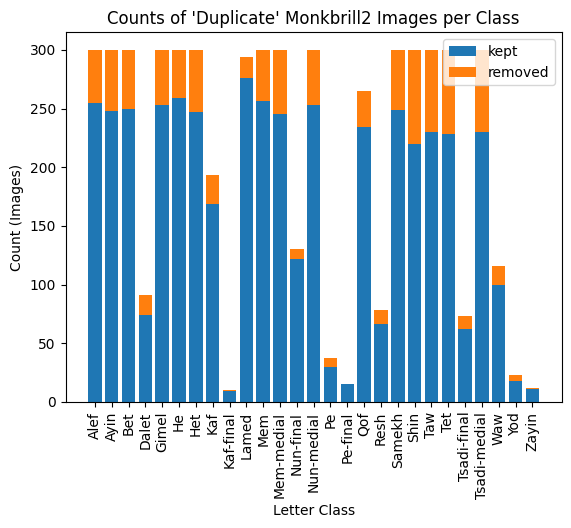

In [128]:
#p1 = plt.bar(letter_classes, kept_list, width, color='b')
#p2 = plt.bar(letter_classes, discarded_list, width, bottom=kept_list, color='r')

fig, ax = plt.subplots()

# Stacked bar chart
ax.bar(letter_classes, kept_list)
ax.bar(letter_classes, discarded_list, bottom = kept_list)

plt.legend(["kept", "removed"])
plt.xticks(rotation = 90)
plt.xlabel("Letter Class")
plt.ylabel("Count (Images)")
plt.title("Counts of 'Duplicate' Monkbrill2 Images per Class")
plt.show()

In [ ]:
from PIL import Image, ImageFont, ImageDraw, ImageChops
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import math
import cv2

path ="Data/dssLetters/train_copy/He/navis-QIrug-Qumran_extr09_2024-line-024-y1=863-y2=981-zone-HUMAN-x=1481-y=0038-w=0036-h=0039-ybas=0057-nink=572-segm=COCOS5cocos.jpg"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img_size = img.shape
print(img_size)

whiteImage = Image.new('L', img_size, 255) 

img = Image.fromarray(img)
# to make the image grainy, use this mask. p is the probability that each pixel is made to be white (hence removing parts of the letters)
p = 0.4
mask = np.random.rand(img_size[0], img_size[1]) > p
mask = Image.fromarray(mask)

#img = ImageChops.composite(img, whiteImage, mask) 


img = np.array(img) 

kernel = np.ones((2, 2), np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2)

plt.imshow(img, cmap='gray')